In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
%matplotlib inline
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from dtreeviz.trees import dtreeviz

#Lojistik Regresyon ve Karar Ağacı kullanarak ilk 50 sütundaki sorulara verilen cevaplardan ülke tahmininin yapılması

In [2]:
data_set = pd.read_csv('C:\\Users\\cengi\\OneDrive\\Masaüstü\\data-final.csv', sep='\t')

In [3]:
print("Veri seti:", data_set.shape)

Veri seti: (1015341, 110)


In [4]:
print('Katılımcı sayısı: ', len(data_set))
data_set.head()

Katılımcı sayısı:  1015341


,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,2016-03-03 02:01:01,768.0,1024.0,9.0,234.0,6,1,GB,51.5448,0.1991
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,...,2016-03-03 02:01:20,1360.0,768.0,12.0,179.0,11,1,MY,3.1698,101.706
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,2016-03-03 02:01:56,1366.0,768.0,3.0,186.0,7,1,GB,54.9119,-1.3833
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,2016-03-03 02:02:02,1920.0,1200.0,186.0,219.0,7,1,GB,51.75,-1.25
4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,...,2016-03-03 02:02:57,1366.0,768.0,8.0,315.0,17,2,KE,1.0,38.0


In [5]:
print('Eksik değeler var mı? ', data_set.isnull().values.any())
print('Ne kadar eksik değer var? ', data_set.isnull().values.sum())
data_set.dropna(inplace=True)
print('Eksik değerlerin olduğu satırları sildikten sonraki katılımcı sayısı: ', len(data_set))

Eksik değeler var mı?  True
Ne kadar eksik değer var?  186358
Eksik değerlerin olduğu satırları sildikten sonraki katılımcı sayısı:  1012050


In [6]:
start_rows = len(data_set)
data_set = data_set.replace(0, np.nan).dropna(axis=0).reset_index(drop=True)
remove_rows = start_rows - len(data_set)

In [7]:
pos_questions = [ # pozitif sorular: karakter özelliğine + etki eder
    'EXT1','EXT3','EXT5','EXT7','EXT9',                       # 5 Dışadönüklük
    'EST1','EST3','EST5','EST6','EST7','EST8','EST9','EST10', # 8 Nevrotiklik
    'AGR2','AGR4','AGR6','AGR8','AGR9','AGR10',               # 6 Uyumluluk
    'CSN1','CSN3','CSN5','CSN7','CSN9','CSN10',               # 6 Sorumluluk
    'OPN1','OPN3','OPN5','OPN7','OPN8','OPN9','OPN10',        # 7 Deneyime Açıklık
]
neg_questions = [ # negatif sorular: karakter özelliğine - etki eder
    'EXT2','EXT4','EXT6','EXT8','EXT10', # 5 Dışadönüklük
    'EST2','EST4',                       # 2 Nevrotiklik
    'AGR1','AGR3','AGR5','AGR7',         # 4 Uyumluluk
    'CSN2','CSN4','CSN6','CSN8',         # 4 Sorumluluk
    'OPN2','OPN4','OPN6',                # 3 Deneyime Açıklık
]


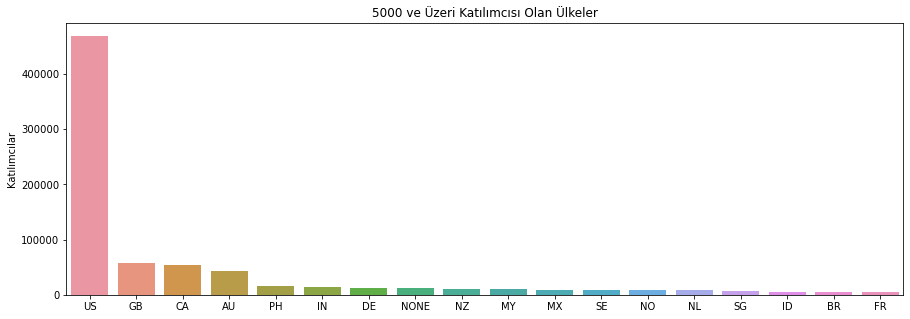

In [8]:
# Katılımcıların ülke dağılımları
countries = pd.DataFrame(data_set['country'].value_counts())
countries_5000 = countries[countries['country'] >= 5000]
plt.figure(figsize=(15,5))
sns.barplot(data=countries_5000, x=countries_5000.index, y='country')
plt.title('5000 ve Üzeri Katılımcısı Olan Ülkeler')
plt.ylabel('Katılımcılar');

In [10]:
answer_data = data_set.iloc[:,0:50]
answer_data = answer_data.astype(int)

In [11]:
answer_data['country'] = data_set['country']

In [12]:
data_set[pos_questions] = data_set[pos_questions].replace({1:-2, 2:-1, 3:0, 4:1, 5:2})
data_set[neg_questions] = data_set[neg_questions].replace({1:2, 2:1, 3:0, 4:-1, 5:-2})
cols = pos_questions + neg_questions
data_set = data_set[sorted(cols)]
data_set.head()

,AGR1,AGR10,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,...,OPN1,OPN10,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9
0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,0.0,1.0
1,2.0,0.0,1.0,2.0,2.0,2.0,2.0,0.0,1.0,2.0,...,-2.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,-1.0,2.0
2,2.0,0.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,...,2.0,1.0,2.0,-1.0,2.0,1.0,1.0,2.0,0.0,1.0
3,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0
4,2.0,0.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0


In [13]:
personality_traits = ["EXT", "AGR", "CSN", "EST", "OPN"]
answer_columns = [trait + str(number) for trait in personality_traits for number in range(1, 11)]
print(answer_columns)
trait_labels = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']

for trait in personality_traits:
    personality_traits_cols = sorted([col for col in data_set.columns if trait in col and '_E' not in col])
    data_set[trait] = data_set[personality_traits_cols].sum(axis=1)
data_set[personality_traits].head()

['EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7', 'EXT8', 'EXT9', 'EXT10', 'AGR1', 'AGR2', 'AGR3', 'AGR4', 'AGR5', 'AGR6', 'AGR7', 'AGR8', 'AGR9', 'AGR10', 'CSN1', 'CSN2', 'CSN3', 'CSN4', 'CSN5', 'CSN6', 'CSN7', 'CSN8', 'CSN9', 'CSN10', 'EST1', 'EST2', 'EST3', 'EST4', 'EST5', 'EST6', 'EST7', 'EST8', 'EST9', 'EST10', 'OPN1', 'OPN2', 'OPN3', 'OPN4', 'OPN5', 'OPN6', 'OPN7', 'OPN8', 'OPN9', 'OPN10']


,EXT,AGR,CSN,EST,OPN
0,16.0,9.0,2.0,-6.0,15.0
1,-10.0,14.0,7.0,-5.0,5.0
2,-5.0,12.0,4.0,-4.0,11.0
3,-4.0,8.0,-5.0,-1.0,9.0
4,-1.0,16.0,18.0,-11.0,18.0


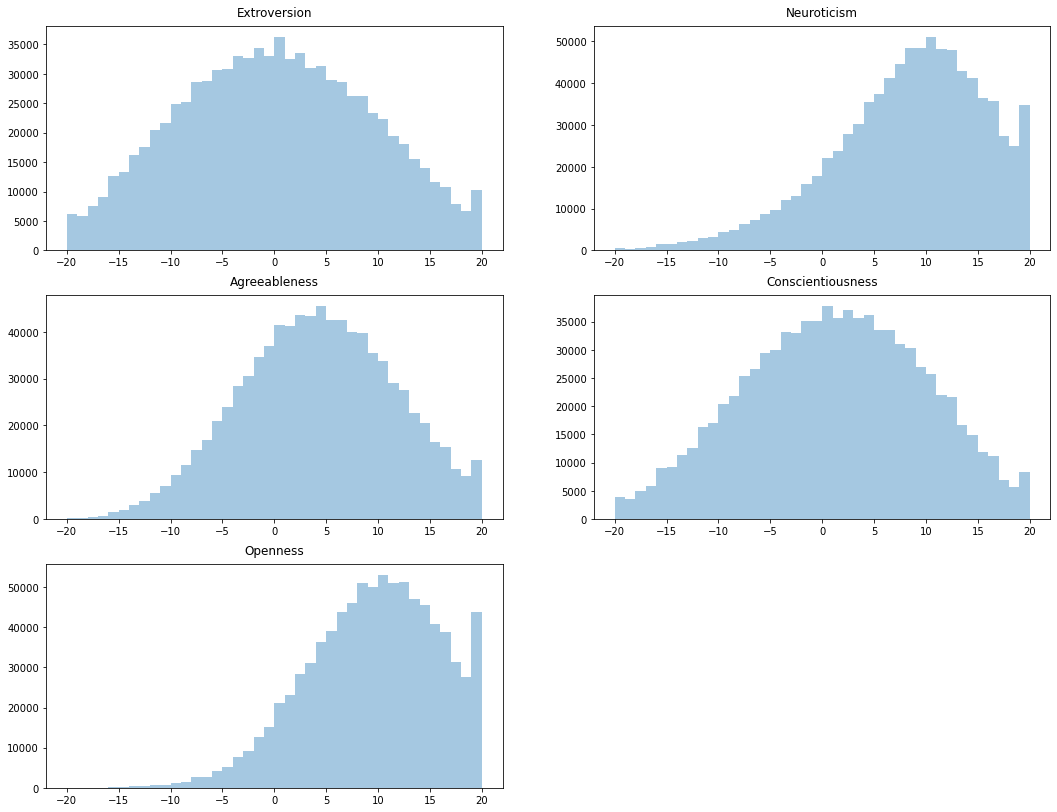

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(18,9))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.3, wspace=None, hspace=None)
row = -1; col = 2
for i, (trait, label) in enumerate(zip(personality_traits, trait_labels)):
    if not i % 2:
        row += 1
    if not i % 2:
        col -= 2
    i += col
    sns.distplot(data_set[trait], ax=axs[row][i], axlabel='', kde=False, bins=40).set_title(label, pad=10)
fig.delaxes(axs[2][1])

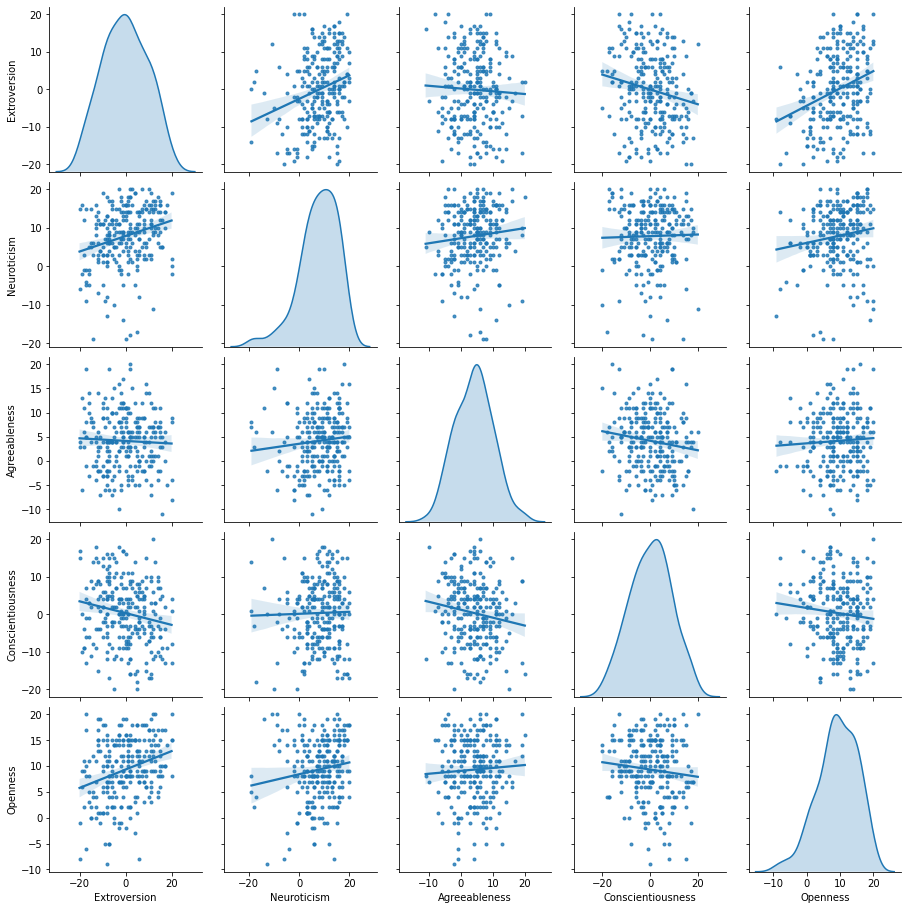

In [15]:
sns.pairplot(data_set[personality_traits].rename(columns={k:v for k, v in zip(personality_traits, trait_labels)}).sample(250), diag_kind="kde", kind="reg", markers=".");

In [16]:
for col in answer_data.columns:
    answer_data[col] = answer_data[col].astype('category').cat.codes

In [17]:
corr_data = pd.DataFrame(answer_data.corr()['country'][:])

In [18]:
corr_data = corr_data.reset_index()

In [19]:
top_correlation = corr_data.sort_values('country', ascending=False).head(10)['index'].to_list()

In [20]:
least_correlation = corr_data.sort_values('country', ascending=False).tail(5)['index'].to_list()

In [21]:
correlation_data = answer_data[top_correlation+least_correlation]

In [22]:
target_data = answer_data['country']

In [23]:
var_train, var_test, res_train, res_test = train_test_split(correlation_data, target_data, test_size = 0.3)

In [24]:
logistic_reg = LogisticRegression(random_state=0, max_iter=100).fit(var_train, res_train)

D:\Users\cengi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
prediction = logistic_reg.predict(var_test)

In [26]:
accuracy_score(res_test, prediction)

0.7134859130541853

In [27]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(var_train, res_train)

In [28]:
decision_prediction = decision_tree.predict(var_test)

In [29]:
accuracy_score(res_test, decision_prediction)

0.9999576737492593

In [30]:
X = answer_data
y = answer_data['country']

In [31]:
regr = DecisionTreeRegressor(max_depth=4, random_state=1234)
model = regr.fit(X, y)

In [32]:
text_representation = tree.export_text(regr)
print(text_representation)

|--- feature_50 <= 124.50
|   |--- feature_50 <= 52.50
|   |   |--- feature_50 <= 24.50
|   |   |   |--- feature_50 <= 7.50
|   |   |   |   |--- value: [1.67]
|   |   |   |--- feature_50 >  7.50
|   |   |   |   |--- value: [12.56]
|   |   |--- feature_50 >  24.50
|   |   |   |--- feature_50 <= 41.50
|   |   |   |   |--- value: [34.70]
|   |   |   |--- feature_50 >  41.50
|   |   |   |   |--- value: [49.13]
|   |--- feature_50 >  52.50
|   |   |--- feature_50 <= 81.50
|   |   |   |--- feature_50 <= 63.50
|   |   |   |   |--- value: [57.96]
|   |   |   |--- feature_50 >  63.50
|   |   |   |   |--- value: [69.25]
|   |   |--- feature_50 >  81.50
|   |   |   |--- feature_50 <= 101.50
|   |   |   |   |--- value: [92.23]
|   |   |   |--- feature_50 >  101.50
|   |   |   |   |--- value: [110.08]
|--- feature_50 >  124.50
|   |--- feature_50 <= 183.50
|   |   |--- feature_50 <= 164.50
|   |   |   |--- feature_50 <= 153.50
|   |   |   |   |--- value: [147.72]
|   |   |   |--- feature_50 >  153.